In [19]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler

# Задание 3

# Часть 1

1. Импортировать данные в DataFrame и вывести несколько первых записей (для контроля корректности импорта и получения представления о наборе).

In [20]:
df = pd.read_csv("HeightsWeights.csv")
df["Fictitious"] = np.ones(25000)
df.head()

,Index,Height,Weight,Fictitious
0,1,65.78331,112.9925,1.0
1,2,71.51521,136.4873,1.0
2,3,69.39874,153.0269,1.0
3,4,68.21660,142.3354,1.0
4,5,67.78781,144.2971,1.0


2. Выполнить  первичный  анализ  данных:  построить  гистограммы  распределения признаков  (с  заголовками)  и  проанализировать  характер  их  распределения, наличие/отсутствие выбросов.

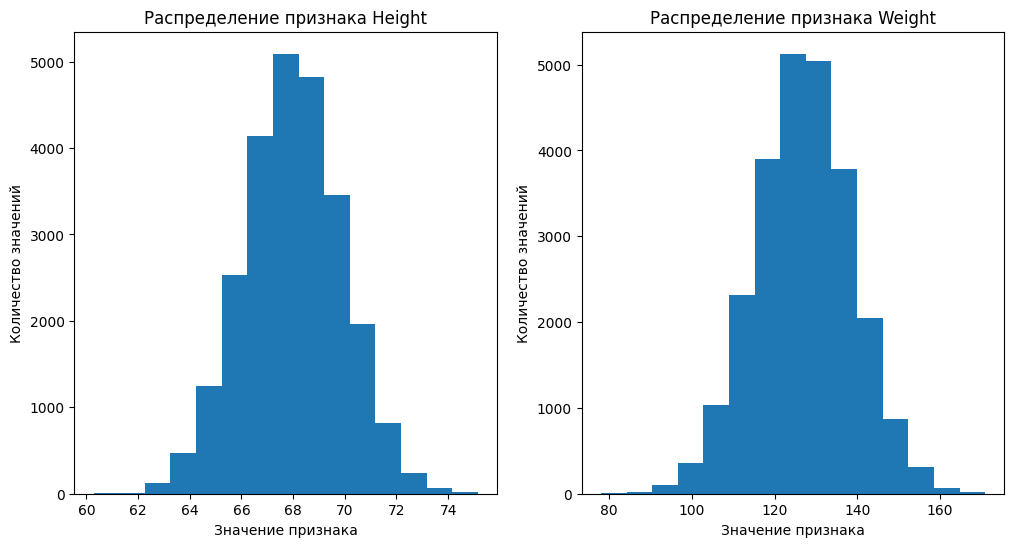

In [21]:
plt.figure(figsize = (12, 6))
columns = ["Height", "Weight"]

for i in range(2): 
  plt.subplot(1, 2, i + 1)
  plt.hist(df[f"{columns[i]}"], bins = 15)
  plt.title(f"Распределение признака {columns[i]}")
  plt.xlabel("Значение признака")
  plt.ylabel("Количество значений")

Как видно из гистограмм оба признака имеют распределение близкое к нормальному и не имеют выбросов. 

3. Добавить в DataFrame новый признак – индекс массы тела (BMI). 

In [22]:
df["BMI"] = (df["Weight"] * 0.453592) / ((df["Height"] * 0.0254) ** 2)
df.head()

,Index,Height,Weight,Fictitious,BMI
0,1,65.78331,112.9925,1.0,18.357609
1,2,71.51521,136.4873,1.0,18.762615
2,3,69.39874,153.0269,1.0,22.338940
3,4,68.21660,142.3354,1.0,21.504569
4,5,67.78781,144.2971,1.0,22.077625


4. Визуализировать  попарные  зависимости  признаков.  Проанализировать  полученные графики: выяснить, есть ли пары признаков, для которых можно предполагать линейную зависимость.

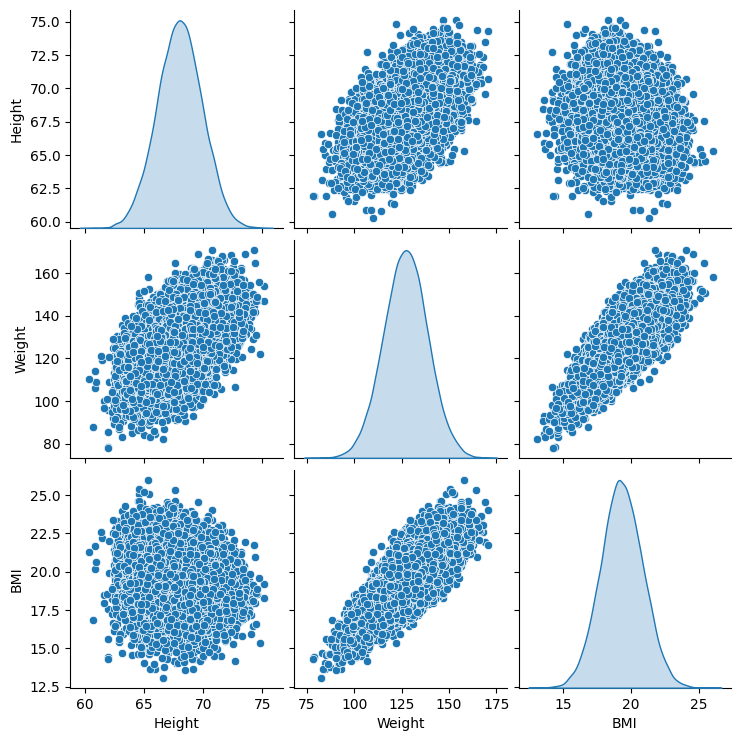

In [23]:
sns.pairplot(df[["Height", "Weight", "BMI"]], diag_kind = "kde")

Можно предполагать линейную зависимость для следующих пар признаков: Height и Weight, Weight и BMI

**Масштабирование признака Weight**

Во время работы алгоритма градиентного спуска возникала следующая проблема: MSE, значения весов и градиента на каждом шаге неограниченно возрастали вплоть до значения inf и программа падала в ошибку, происходило это при разных значениях шага(чем меньше шаг, тем меньше было увеличение вышеуказанных параметров на каждом шаге, но рано или поздно они все равно достигали значения inf). 

При этом значение MSE и градиент вычислялись гарантированно правильно (MSE проверена методом из sklearn, градиент был высчитан "руками"). Для проверки правильности реализации алгоритма была реализована его тестовая версия - методы testMSE, test_grad и test_grad_descent соответственно. Запуск тестового градиентого спуска на исходных данных X = [1, 2, 3], Y = [3, 5, 7] показал, что тестовый градиентный спуск работает правильно и хорошо сходится. Значит и исходный алгоритм реализован верно. Все это привело к мысли о том, что алгоритм работает неправильно из-за формата входных данных, и поэтому было решено провести стандартизацию признака Weight. 

In [24]:
scaler = StandardScaler() 
weight = np.array(df["Weight"])
weight = weight.reshape(-1, 1)
df["WeightScaled"] = scaler.fit_transform(weight)
df.head()

,Index,Height,Weight,Fictitious,BMI,WeightScaled
0,1,65.78331,112.9925,1.0,18.357609,-1.208072
1,2,71.51521,136.4873,1.0,18.762615,0.806805
2,3,69.39874,153.0269,1.0,22.338940,2.225214
3,4,68.21660,142.3354,1.0,21.504569,1.308328
4,5,67.78781,144.2971,1.0,22.077625,1.476561


5. Написать функцию, которая по двум параметрам $𝑤_0$ и $𝑤_1$ вычисляет квадратичную ошибку  приближения  зависимости  роста $𝑦$ от веса $𝑥$ линейной  функцией $𝑦 = 𝑤_0 + 𝑤_1 * 𝑥$.

In [25]:
x = np.array([1, 2, 3])
y = np.array([3, 5, 7])

def MSE(w0, w1): 
  w = np.array([w0, w1])
  return np.square(df[["Fictitious", "WeightScaled"]].dot(w) - df["Height"]).mean()

def sMSE(w0, w1, index):
  w = np.array([w0, w1])
  return np.square(df[["Fictitious", "WeightScaled"]].iloc[index].dot(w) - df["Height"].iloc[index])

def testMSE(w0, w1):  
  prediction = np.array((x * w1 + w0) - y) 
  return np.square(prediction).mean()

6. Реализовать  метод  градиентного  спуска  для  минимизации  ошибки,  обеспечив сохранение на каждой итерации текущего значения ошибки (использовать собственный программный код, а не встроенные классы sklearn). Условие останова $–‖∇𝑄(𝑤𝑡)‖<𝜀$ ($𝜀$–параметр, значение которого по умолчанию равно $10^{–5}$).

In [26]:
def grad(w0, w1): 
  sum_w0 = np.sum(w1 * df["WeightScaled"] + w0 - df["Height"])
  sum_w1 = np.sum((w1 * df["WeightScaled"] + w0 - df["Height"]) * df["WeightScaled"])
  return np.array([(2.0 / len(df)) * sum_w0, (2.0 / len(df)) * sum_w1])
  
def grad_descend(step_size, eps = 10e-5):
  iterations = 0 
  w = np.zeros(2) 
  mse = [] 
  while(np.sqrt(np.sum(np.square(grad(w[0], w[1])))) >= eps): 
    gradient = grad(w[0], w[1])
    w = w - step_size * gradient
    iterations += 1
    mse.append(MSE(w[0], w[1]))
  return w, iterations, mse

7. Применить  градиентный  спуск  к  имеющемуся  набору  данных;  вывести  уравнение полученной линейной зависимости с оптимальными значениями коэффициентов и число итераций, выполненных алгоритмом до достижения условия останова.

In [27]:
coeff, iterations_count, mse = grad_descend(0.0001)

In [28]:
print(f"Количество итераций: {iterations_count}")
print(f"Уравнение: y = {np.round(coeff[0], 3)} + {np.round(coeff[1], 3)} * x")

Количество итераций: 70608
Уравнение: y = 67.993 + 0.956 * x


8. Вывести на одном графике исходный набор данных в координатах вес – рост и прямую регрессии с оптимальными значениями коэффициентов.

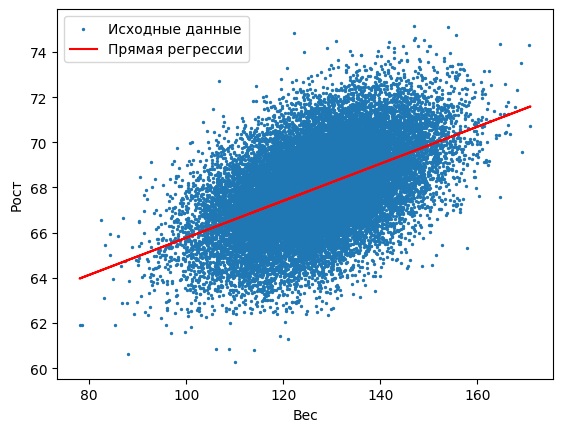

In [29]:
plt.scatter(df["Weight"], df["Height"], s = 2, label = "Исходные данные")
plt.plot(df["Weight"], df["WeightScaled"] * coeff[1] + coeff[0], color = 'red', label = "Прямая регрессии")
plt.xlabel("Вес")
plt.ylabel("Рост")
plt.legend()

9. Вывести график, показывающий изменение значения ошибки алгоритма в зависимости от номера итерации.

Text(0, 0.5, 'MSE')

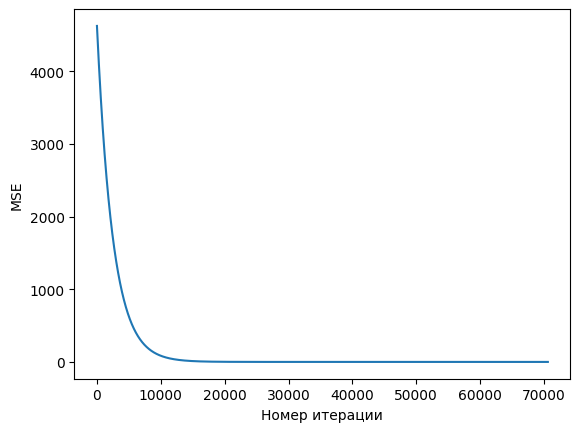

In [30]:
plt.plot(np.linspace(0, iterations_count, iterations_count), mse)
plt.xlabel("Номер итерации")
plt.ylabel("MSE")

#Часть 2

1. Реализовать метод стохастического градиентного спуска для минимизации ошибки, обеспечив сохранение на каждой итерации текущего значения ошибки

In [31]:
def stochastic_grad(w0, w1, random_index): 
  new_w0 = w1 * df["WeightScaled"].iloc[random_index] + w0 - df["Height"].iloc[random_index]
  new_w1 = (w1 * df["WeightScaled"].iloc[random_index] + w0 - df["Height"].iloc[random_index]) * df["WeightScaled"].iloc[random_index]
  return np.array([2 * new_w0, 2 * new_w1])

def stochastic_grad_descend(step_size, eps = 10e-5):
  iterations = 0 
  w = np.zeros(2) 
  mse = [] 
  random_index = np.random.randint(0, 25000)
  while(np.sqrt(np.sum(np.square(stochastic_grad(w[0], w[1], random_index)))) >= eps): 
    random_index = np.random.randint(0, 25000)
    gradient = stochastic_grad(w[0], w[1], random_index)
    w = w - step_size * gradient
    iterations += 1
    mse.append(sMSE(w[0], w[1], random_index))
    #mse.append(MSE(w[0], w[1]))
  return w, iterations, mse

2. Применить стохастический градиентный спуск к имеющемуся набору данных; вывести уравнение полученной  линейной  зависимости  с  оптимальными  значениями коэффициентов и число итераций, выполненных алгоритмом до достижения условия останова.

In [32]:
s_coeff, s_iterations_count, s_mse = stochastic_grad_descend(0.0001)

In [33]:
print(f"Количество итераций: {s_iterations_count}")
print(f"Уравнение: y = {np.round(s_coeff[0], 3)} + {np.round(s_coeff[1], 3)} * x")

Количество итераций: 52481
Уравнение: y = 67.991 + 0.931 * x


3. Вывести на одном графике исходный набор данных в координатах вес – рост и прямую регрессии  с  оптимальными  значениями  коэффициентов,  полученных  с  помощью стохастического градиентного спуска.

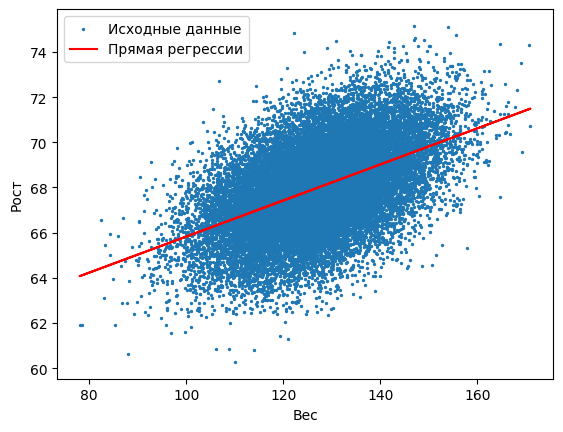

In [34]:
plt.scatter(df["Weight"], df["Height"], s = 2, label = "Исходные данные")
plt.plot(df["Weight"], df["WeightScaled"] * s_coeff[1] + s_coeff[0], color = 'red', label = "Прямая регрессии")
plt.xlabel("Вес")
plt.ylabel("Рост")
plt.legend()

4. Вывести график, показывающий изменение значения ошибки алгоритма в зависимости от номера итерации. Сопоставить этот график с графиком, полученным в п. 9. части 1.

Text(0, 0.5, 'MSE')

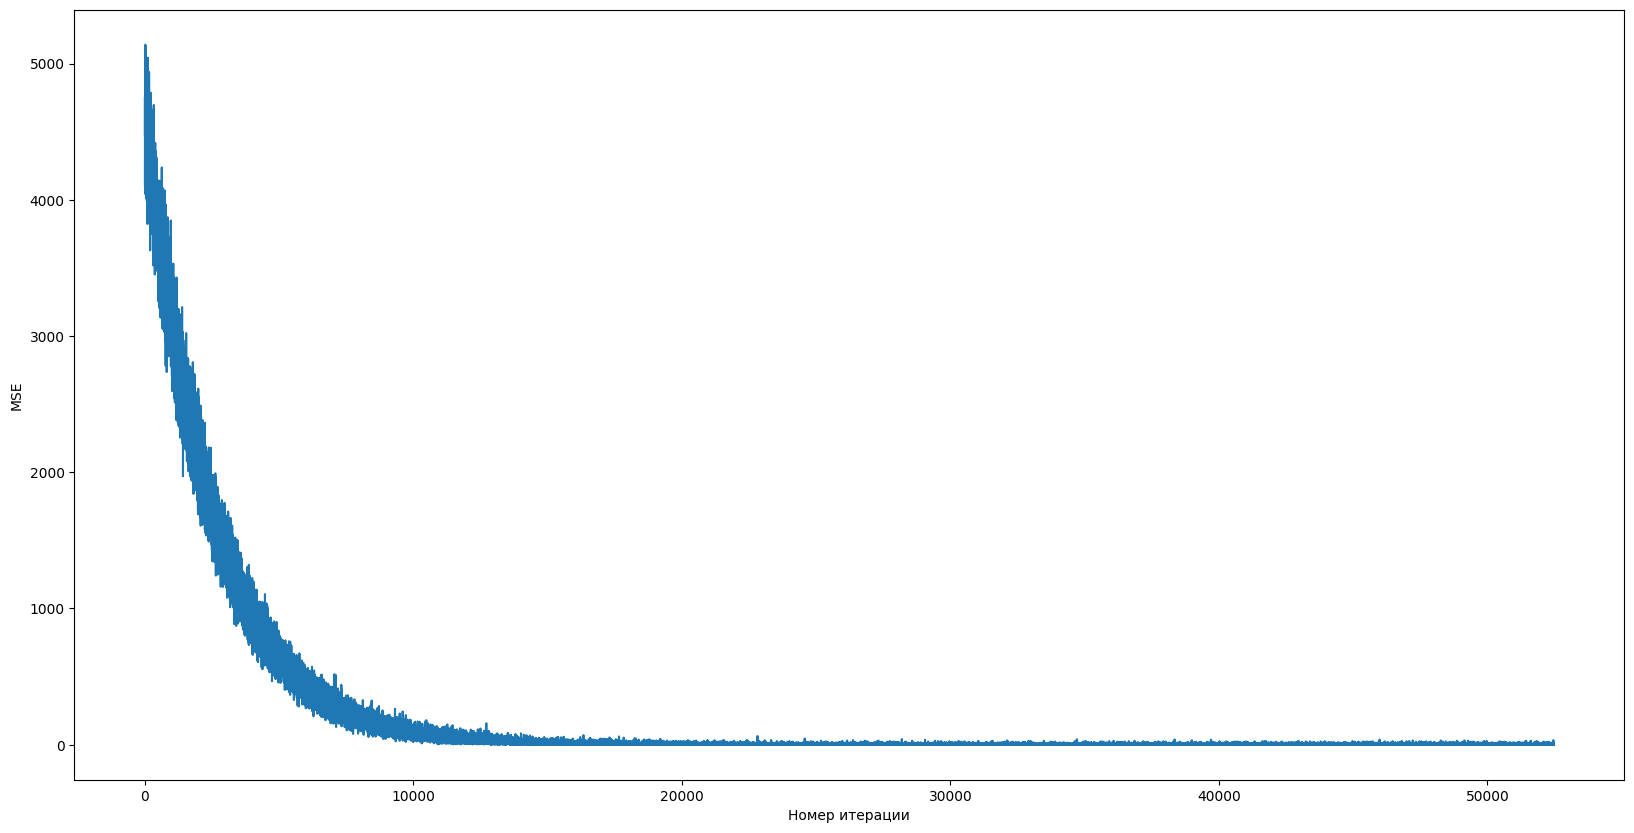

In [35]:
plt.figure(figsize = (20, 10))
plt.plot(np.linspace(0, s_iterations_count, s_iterations_count), s_mse)
plt.xlabel("Номер итерации")
plt.ylabel("MSE")

5. Сравнить результаты работы алгоритмов Full  GD и SGD по достигнутому значению функции ошибки, числу итераций и затраченному времени.

In [36]:
  print('\033[1m' + "heelo" + '\033[1m')
  steps = [0.01, 0.001, 0.0001]
  for step in steps: 
    coeff, iterations_count, mse = grad_descend(step)
    s_coeff, s_iterations_count, s_mse = stochastic_grad_descend(step)
    print(f"Сравнение алгоритмов Full GD и SGD при шаге {step}\n")
    print(f"MSE\n FullGD: {mse[len(mse) - 1]} \n SGD: {s_mse[len(s_mse) - 1]}\n")
    print(f"Количество итераций\n FullGD: {iterations_count}\n SGD: {s_iterations_count}\n\n")

  print("Затраченное время при шаге 0.01 \n FullGD: 5.727 секунд  \n SGD: 24.262 секунд\n")
  print("Затраченное время при шаге 0.001 \n FullGD: 40.684 секунд \n SGD: 82.048 секунд\n")
  print("Затраченное время при шаге 0.0001 \n FullGD: 420.696 секунд \n SGD: 44.916  секунд\n")

heelo
Сравнение алгоритмов Full GD и SGD при шаге 0.01

MSE
 FullGD: 2.701811485818097 
 SGD: 1.8461974168061732e-10

Количество итераций
 FullGD: 700
 SGD: 104031


Сравнение алгоритмов Full GD и SGD при шаге 0.001

MSE
 FullGD: 2.70181148590517 
 SGD: 1.3901742063032102e-09

Количество итераций
 FullGD: 7055
 SGD: 21664


Сравнение алгоритмов Full GD и SGD при шаге 0.0001

MSE
 FullGD: 2.7018114859107465 
 SGD: 7.577921667056692e-10

Количество итераций
 FullGD: 70608
 SGD: 40116


Затраченное время при шаге 0.01 
 FullGD: 5.727 секунд  
 SGD: 24.262 секунд

Затраченное время при шаге 0.001 
 FullGD: 40.684 секунд 
 SGD: 82.048 секунд

Затраченное время при шаге 0.0001 
 FullGD: 420.696 секунд 
 SGD: 44.916  секунд



6. Проанализировать полученные результаты, сделать выводы.

Оба алгоритма работают с примерно одной и той же точностью и выдают примерно одни и те же коэффициенты. Однако разница в времени выполнения существенная: на "больших" шагах (0.01 и 0.001) Full GD работает намного быстрее (следовательно за меньшее количество итераций). Однако начиная с шага 0.0001 быстрее оказывается SGD, причем имея бОльшее количество итераций, чем Full GD. 

#Часть 3